In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [2]:
nasdaq = pd.read_csv('NasDaq100 Daily Returns.csv')
nasdaq.head(10)

,PERMNO,date,SICCD,TICKER,COMNAM,HSICIG,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,NUMTRD,RETX,sprtrn,enterdate,positive,negative,total,market_cap
0,10104,2023-01-03,7372.0,ORCL,ORACLE CORP,NaN,82.260,83.8400,83.72,8997534.0,0.024223,2696253.0,NaN,0.024223,-0.004001,NaN,0.0,0.0,0.0,2.257303e+08
1,10104,2023-01-04,7372.0,ORCL,ORACLE CORP,NaN,83.640,85.1700,84.48,7836238.0,0.009078,2696253.0,NaN,0.009078,0.007539,NaN,0.0,0.0,0.0,2.277795e+08
2,10104,2023-01-05,7372.0,ORCL,ORACLE CORP,NaN,83.220,85.4000,84.31,7643784.0,-0.002012,2696253.0,NaN,-0.002012,-0.011646,NaN,0.0,0.0,0.0,2.273211e+08
3,10104,2023-01-06,7372.0,ORCL,ORACLE CORP,NaN,83.820,86.3400,85.66,8641597.0,0.016012,2696253.0,NaN,0.016012,0.022841,NaN,0.0,0.0,0.0,2.309610e+08
4,10104,2023-01-09,7372.0,ORCL,ORACLE CORP,NaN,86.160,87.5900,86.42,7519836.0,0.012608,2696253.0,NaN,0.008872,-0.000768,NaN,0.0,0.0,0.0,2.330102e+08
5,10104,2023-01-10,7372.0,ORCL,ORACLE CORP,NaN,85.570,86.6100,86.50,5703270.0,0.000926,2696253.0,NaN,0.000926,0.006978,NaN,0.0,0.0,0.0,2.332259e+08
6,10104,2023-01-11,7372.0,ORCL,ORACLE CORP,NaN,87.090,88.6600,88.60,8359667.0,0.024277,2696253.0,NaN,0.024277,0.012849,NaN,0.0,0.0,0.0,2.388880e+08
7,10104,2023-01-12,7372.0,ORCL,ORACLE CORP,NaN,88.170,89.1950,88.78,6071099.0,0.002032,2696253.0,NaN,0.002032,0.003416,2023-01-12,1.0,0.0,1.0,2.393733e+08
8,10104,2023-01-13,7372.0,ORCL,ORACLE CORP,NaN,87.660,89.4662,89.20,5090938.0,0.004731,2696253.0,NaN,0.004731,0.003997,NaN,0.0,0.0,0.0,2.405058e+08
9,10104,2023-01-17,7372.0,ORCL,ORACLE CORP,NaN,88.425,89.4400,88.60,6550412.0,-0.006726,2696253.0,NaN,-0.006726,-0.002030,2023-01-17,0.0,0.0,1.0,2.388880e+08


             SICCD    market_cap        SHROUT           VOL            PRC  \
count  1195.000000  1.195000e+03  1.195000e+03  1.195000e+03    1195.000000   
mean   4803.827615  2.486838e+08  1.795146e+06  1.122588e+07    2797.388829   
std    1875.306418  3.775104e+08  2.307175e+06  1.893301e+07   25450.117548   
min    1382.000000  5.731128e+07  3.489000e+04  2.364976e+05      14.242609   
25%    3550.000000  9.831970e+07  4.660013e+05  2.261987e+06      94.189131   
50%    4119.000000  1.338303e+08  1.088378e+06  4.896521e+06     163.379999   
75%    6282.000000  2.441182e+08  2.023770e+06  1.025665e+07     290.298246   
max    9999.000000  3.022032e+09  1.583174e+07  1.947476e+08  275845.278937   

               ASKHI        BIDLO        total     negative     positive  \
count    1195.000000  1195.000000  1195.000000  1195.000000  1195.000000   
mean     5520.416277   226.468581    12.189958     0.102929     1.739749   
std     52405.073827   289.428247    11.881671     0.352474 

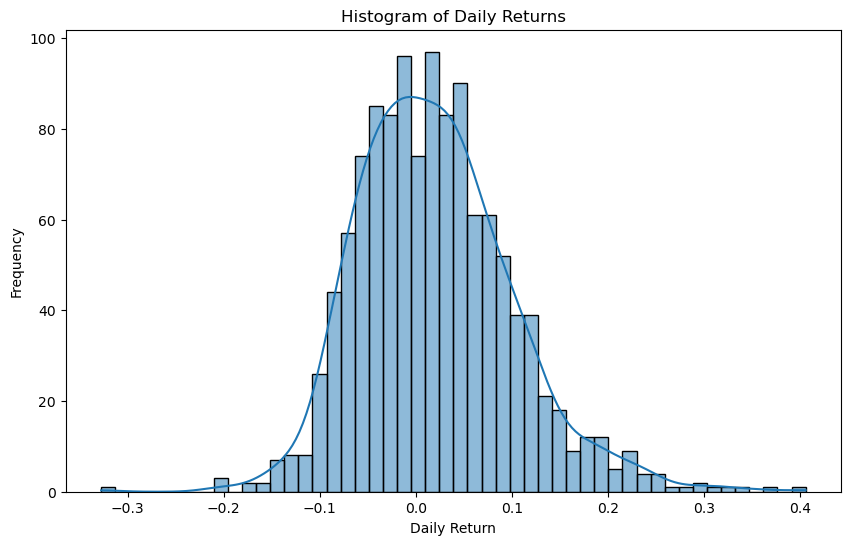

In [3]:
# Change date format
nasdaq['date'] = pd.to_datetime(nasdaq['date'], format='%Y-%m-%d')

# Remove the columns HSICIG and enterdate
nasdaq.drop(columns=['HSICIG', 'enterdate', 'NUMTRD'], inplace=True)

# Reset index
nasdaq.reset_index(drop=True, inplace=True)


# Group by month and ticker and perform aggregations
agg_columns = {
    'SICCD': 'first',
    'COMNAM': 'first',
    'market_cap': 'mean',
    'SHROUT': 'mean',
    'VOL': 'mean',
    'PRC': 'mean',
    'ASKHI': 'max',
    'BIDLO': 'min',
    'total': 'sum',
    'negative': 'sum',
    'positive': 'sum',
    'sprtrn': lambda x: (1 + x).prod() - 1,
    'RET': lambda x: (1 + x).prod() - 1
}

# Group by 'TICKER' and resample the data to monthly frequency
nasdaq = nasdaq.groupby('TICKER').resample('M', on='date').agg(agg_columns).reset_index()

# Adding lagged columns
nasdaq['next_month_return'] = nasdaq.groupby('TICKER')['RET'].shift(-1)
nasdaq['last_month_return'] = nasdaq.groupby('TICKER')['RET'].shift(1)
nasdaq['last_month_volume'] = nasdaq.groupby('TICKER')['VOL'].shift(1)

# Add columns for moving averages
nasdaq['1_month_ma'] = nasdaq.groupby('TICKER')['PRC'].rolling(window=1).mean().reset_index(drop=True)
nasdaq['2_month_ma'] = nasdaq.groupby('TICKER')['PRC'].rolling(window=2).mean().reset_index(drop=True)
nasdaq['3_month_ma'] = nasdaq.groupby('TICKER')['PRC'].rolling(window=3).mean().reset_index(drop=True)

# Create "proper?" column
nasdaq['proper?'] = (nasdaq['1_month_ma'] > nasdaq['2_month_ma']) & (nasdaq['2_month_ma'] > nasdaq['3_month_ma']).astype(int)

# Create price minus 
nasdaq['Ask_minus_Bid'] = nasdaq['ASKHI'] - nasdaq['BIDLO']

# Create comp_size column
nasdaq['comp_size'] = pd.qcut(nasdaq['market_cap'], q=10, labels=False)

# Display summary statistics
print(nasdaq.describe())

# Plot histogram of returns
plt.figure(figsize=(10, 6))
sns.histplot(data=nasdaq, x='RET', bins=50, kde=True)
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()


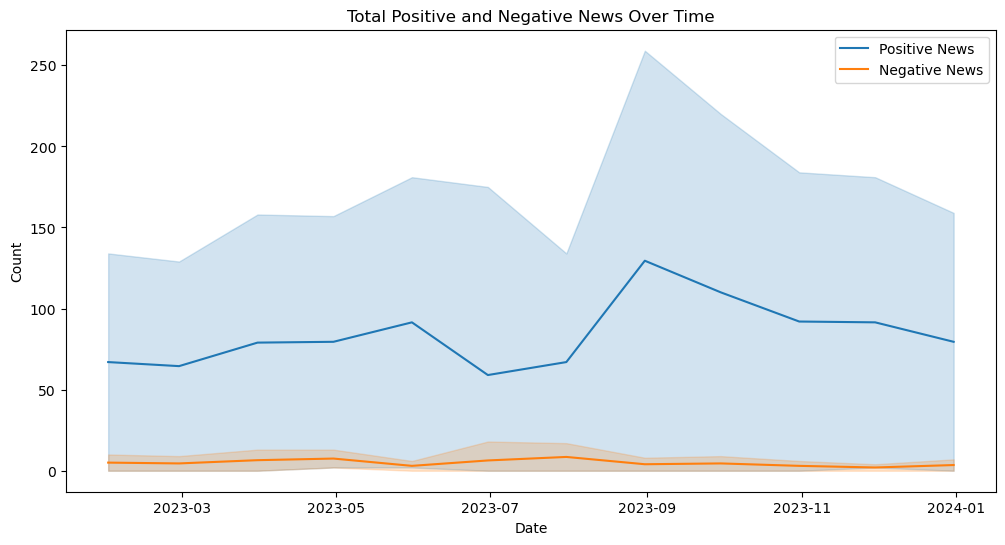

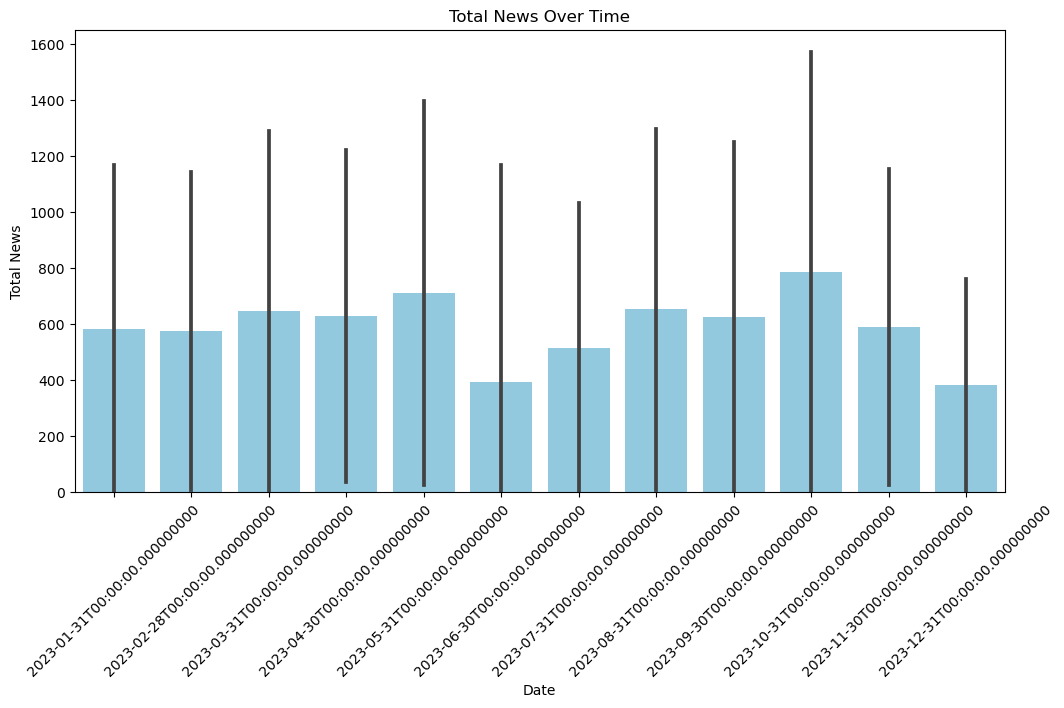

In [4]:
# Daily aggregation
daily_summary = nasdaq.groupby(['date', 'sprtrn']).agg(
    sum_positive=('positive', 'sum'),
    sum_negative=('negative', 'sum'),
    sum_total=('total', 'sum')
).reset_index()

# Plot line chart of total positive and negative news over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_summary, x='date', y='sum_positive', label='Positive News')
sns.lineplot(data=daily_summary, x='date', y='sum_negative', label='Negative News')
plt.title('Total Positive and Negative News Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

# Plot bar chart of total news over time
plt.figure(figsize=(12, 6))
sns.barplot(data=daily_summary, x='date', y='sum_total', color='skyblue')
plt.title('Total News Over Time')
plt.xlabel('Date')
plt.ylabel('Total News')
plt.xticks(rotation=45)
plt.show()

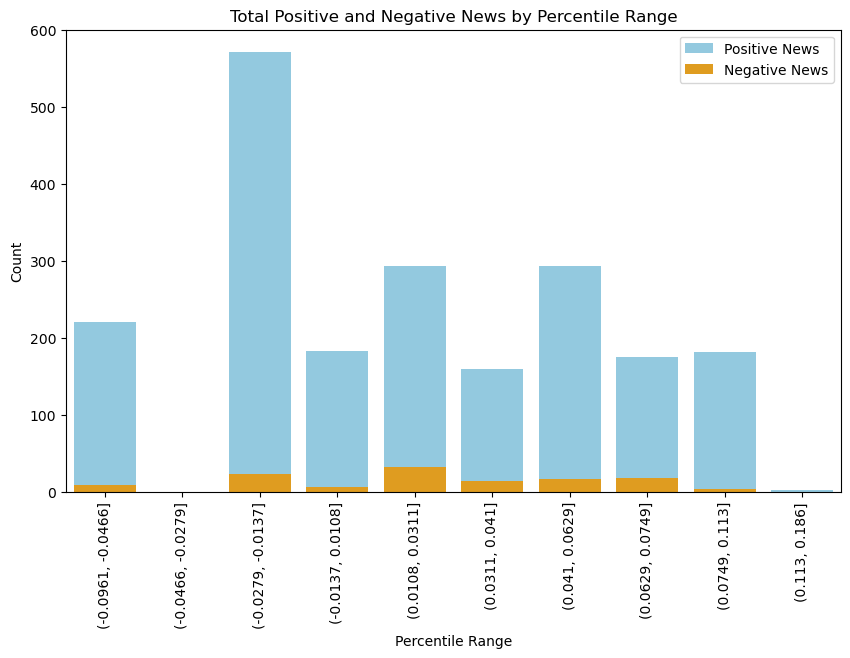

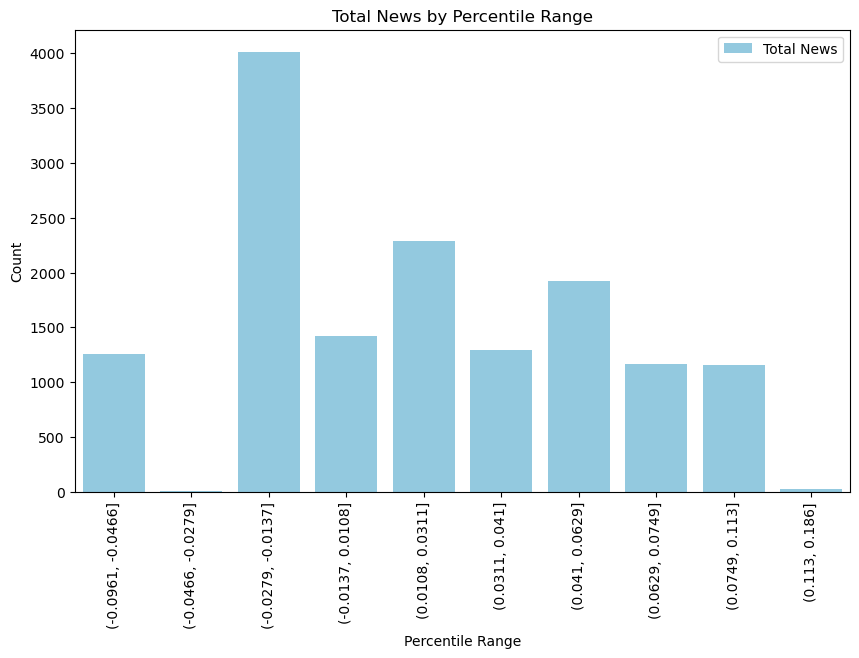

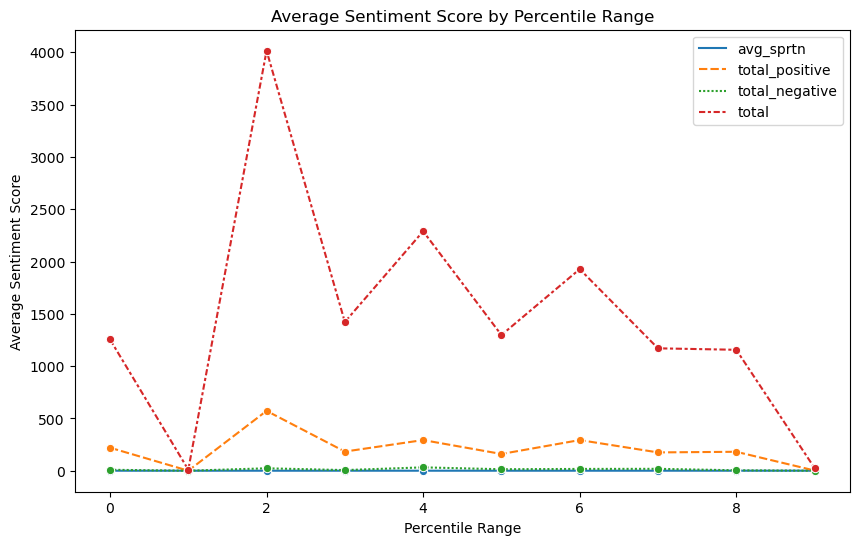

In [5]:
# Percentile summary
ranked_sprtrn = daily_summary.copy()
ranked_sprtrn['sprtrn_percentile'] = pd.qcut(ranked_sprtrn['sprtrn'], q=10, labels=False)
ranked_sprtrn['percentile_range'] = pd.qcut(ranked_sprtrn['sprtrn'], q=10)

percentile_summary = ranked_sprtrn.groupby('percentile_range').agg(
    avg_sprtn=('sprtrn', 'mean'),
    total_positive=('sum_positive', 'sum'),
    total_negative=('sum_negative', 'sum'),
    total=('sum_total', 'sum')
).reset_index()

# Plot bar chart of total positive and negative news by percentile range
plt.figure(figsize=(10, 6))
sns.barplot(data=percentile_summary, x='percentile_range', y='total_positive', color='skyblue', label='Positive News')
sns.barplot(data=percentile_summary, x='percentile_range', y='total_negative', color='orange', label='Negative News')
plt.title('Total Positive and Negative News by Percentile Range')
plt.xlabel('Percentile Range')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()

# Plot bar chart of total positive and negative news by percentile range
plt.figure(figsize=(10, 6))
sns.barplot(data=percentile_summary, x='percentile_range', y='total', color='skyblue', label='Total News')
plt.title('Total News by Percentile Range')
plt.xlabel('Percentile Range')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()

# Plot line chart of average sentiment score by percentile range
plt.figure(figsize=(10, 6))
sns.lineplot(data=percentile_summary.drop(columns='percentile_range'), marker='o', color='green')
plt.title('Average Sentiment Score by Percentile Range')
plt.xlabel('Percentile Range')
plt.ylabel('Average Sentiment Score')
plt.show()


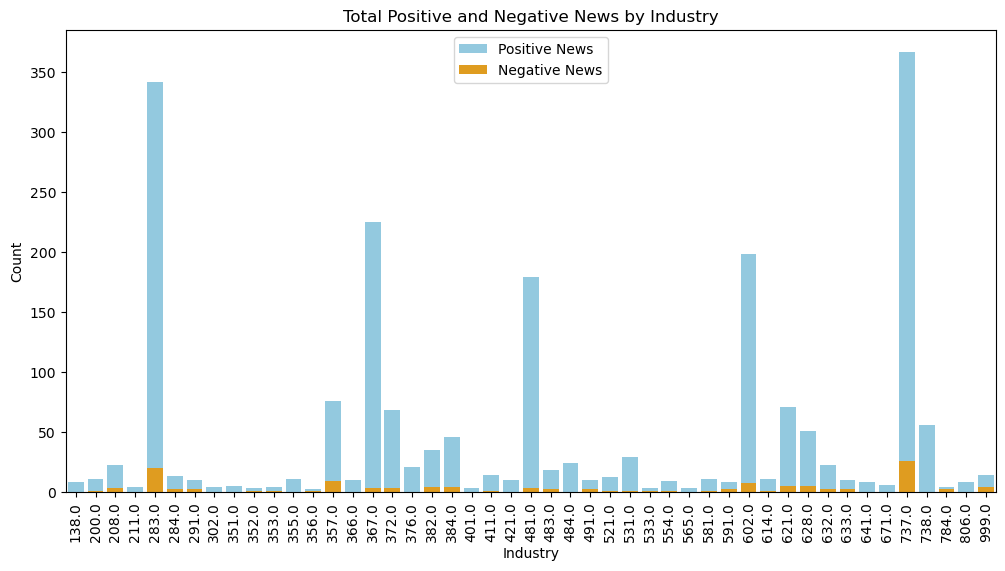

In [6]:
# Industry summary
industry_summary = nasdaq.groupby(nasdaq['SICCD'] // 10).agg(
    num_firms=('TICKER', 'nunique'),
    cum_ret=('RET', 'sum'),
    total_positive=('positive', 'sum'),
    total_negative=('negative', 'sum'),
    total=('total', 'sum')
).reset_index()

industry_summary['positive_perc'] = industry_summary['total_positive'] / industry_summary['total']
industry_summary['negative_perc'] = industry_summary['total_negative'] / industry_summary['total']

# Plot bar chart of total positive and negative news by industry
plt.figure(figsize=(12, 6))
sns.barplot(data=industry_summary, x='SICCD', y='total_positive', color='skyblue', label='Positive News')
sns.barplot(data=industry_summary, x='SICCD', y='total_negative', color='orange', label='Negative News')
plt.title('Total Positive and Negative News by Industry')
plt.xlabel('Industry')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()


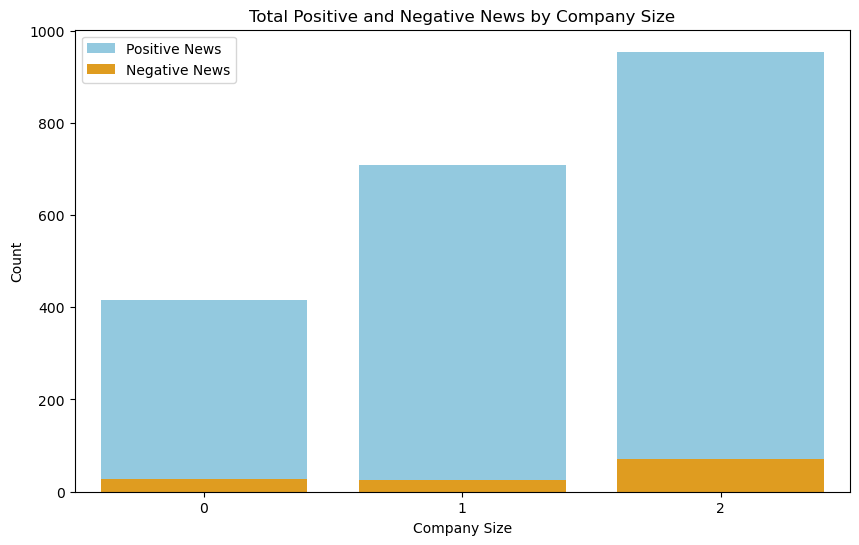

In [7]:
# Company size summary
stock_size = nasdaq.copy()
stock_size['comp_size'] = pd.qcut(stock_size['market_cap'], q=3, labels=False)
company_size_summary = stock_size.groupby('comp_size').agg(
    sum_ret=('RET', 'sum'),
    total_positive=('positive', 'sum'),
    total_negative=('negative', 'sum'),
    total=('total', 'sum')
).reset_index()

company_size_summary['positive_perc'] = company_size_summary['total_positive'] / company_size_summary['total']
company_size_summary['negative_perc'] = company_size_summary['total_negative'] / company_size_summary['total']

# Plot bar chart of total positive and negative news by company size
plt.figure(figsize=(10, 6))
sns.barplot(data=company_size_summary, x='comp_size', y='total_positive', color='skyblue', label='Positive News')
sns.barplot(data=company_size_summary, x='comp_size', y='total_negative', color='orange', label='Negative News')
plt.title('Total Positive and Negative News by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Count')
plt.legend()
plt.show()


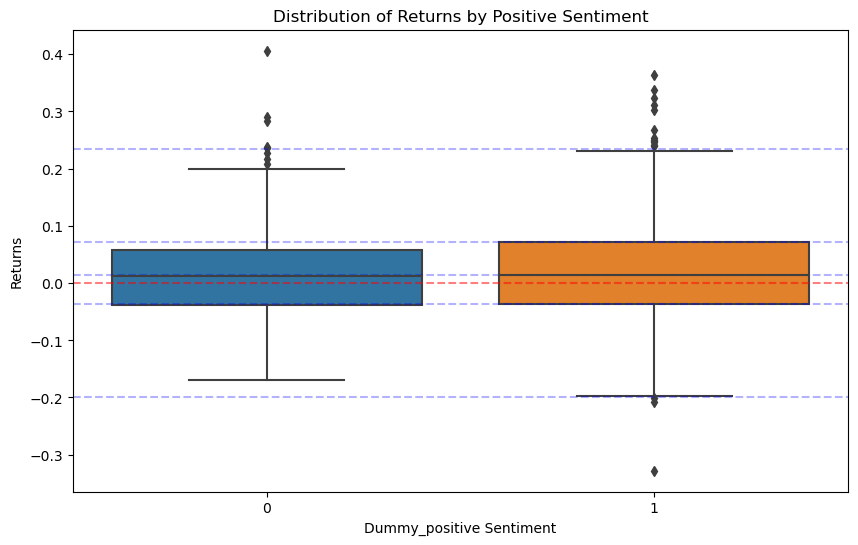

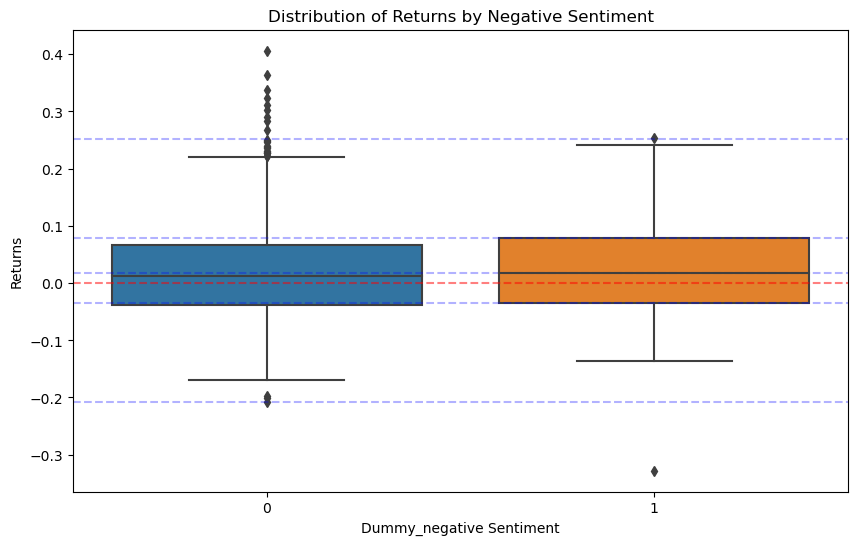

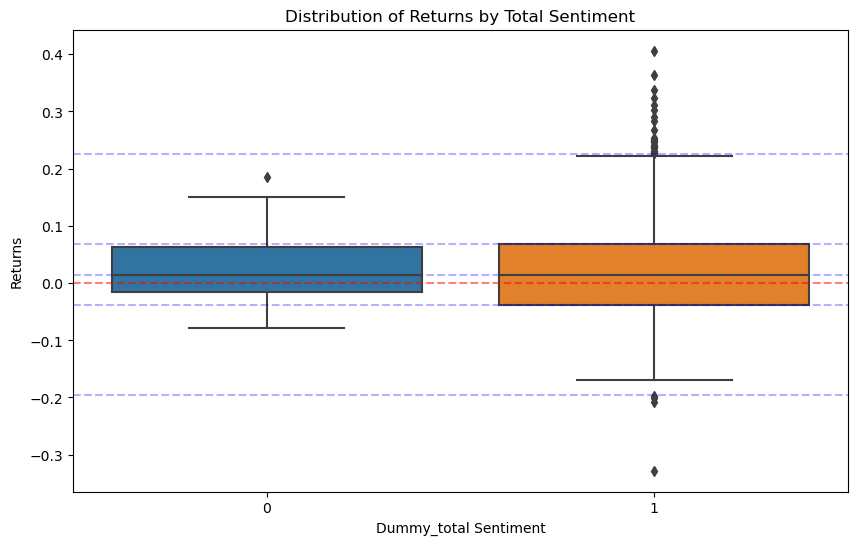

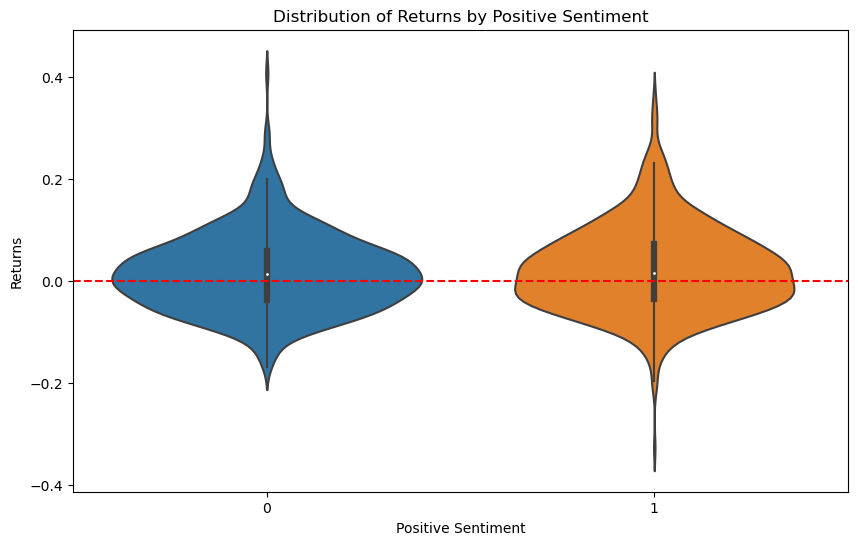

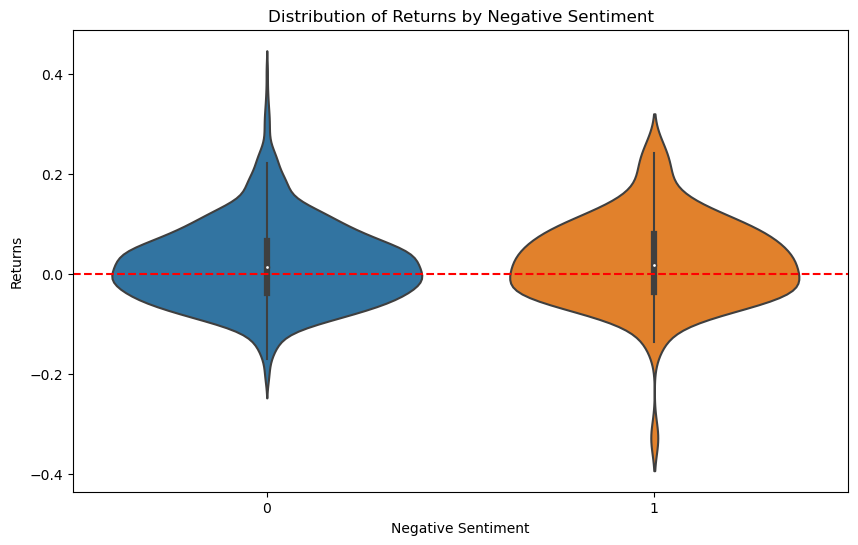

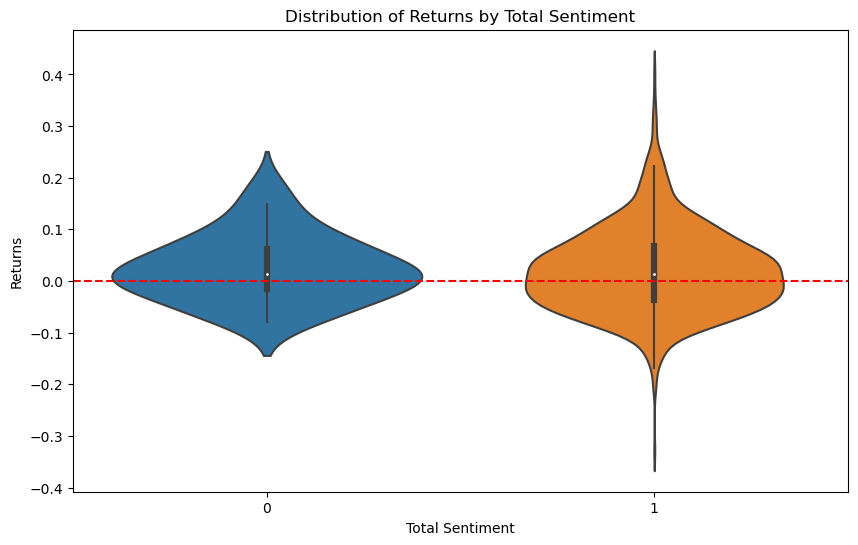

In [8]:
# Create dummy_negative column
nasdaq['dummy_negative'] = (nasdaq['negative'] >= 1).astype(int)

# Create dummy_positive column
nasdaq['dummy_positive'] = (nasdaq['positive'] >= 1).astype(int)

# Create dummy_total column
nasdaq['dummy_total'] = (nasdaq['total'] >= 1).astype(int)


# Function to plot with additional lines
def plot_with_lines(data, x_col, y_col, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_col, y=y_col, data=data)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    # Add blue dashed lines for critical points of value >= 1 category
    for i, box in enumerate(data.groupby(x_col)[y_col]):
        if box[0] == 1:
            quartiles = box[1].quantile([0.25, 0.5, 0.75])
            plt.axhline(y=quartiles[0.25], color='blue', linestyle='--', alpha=0.3)
            plt.axhline(y=quartiles[0.5], color='blue', linestyle='--', alpha=0.3)
            plt.axhline(y=quartiles[0.75], color='blue', linestyle='--', alpha=0.3)              
            iqr = quartiles[0.75] - quartiles[0.25]
            upper_limit = 1.5 * iqr + quartiles[0.75]
            lower_limit = quartiles[0.25] - 1.5 * iqr
            # Add additional blue dashed lines
            plt.axhline(y=upper_limit, color='blue', linestyle='--', alpha=0.3)  # Upper limit
            plt.axhline(y=lower_limit, color='blue', linestyle='--', alpha=0.3)  # Lower limit
    plt.title(title)
    plt.xlabel(x_col.capitalize() + ' Sentiment')
    plt.ylabel('Returns')
    plt.show()


# Box plot for dummy_positive
plot_with_lines(nasdaq, 'dummy_positive', 'RET', 'Distribution of Returns by Positive Sentiment')

# Box plot for dummy_negative
plot_with_lines(nasdaq, 'dummy_negative', 'RET', 'Distribution of Returns by Negative Sentiment')

# Box plot for dummy_total
plot_with_lines(nasdaq, 'dummy_total', 'RET', 'Distribution of Returns by Total Sentiment')

# Violin plot for dummy_positive
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_positive', y='RET', data=nasdaq)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Positive Sentiment')
plt.xlabel('Positive Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_negative
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_negative', y='RET', data=nasdaq)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Negative Sentiment')
plt.xlabel('Negative Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_total
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_total', y='RET', data=nasdaq)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Total Sentiment')
plt.xlabel('Total Sentiment')
plt.ylabel('Returns')
plt.show()


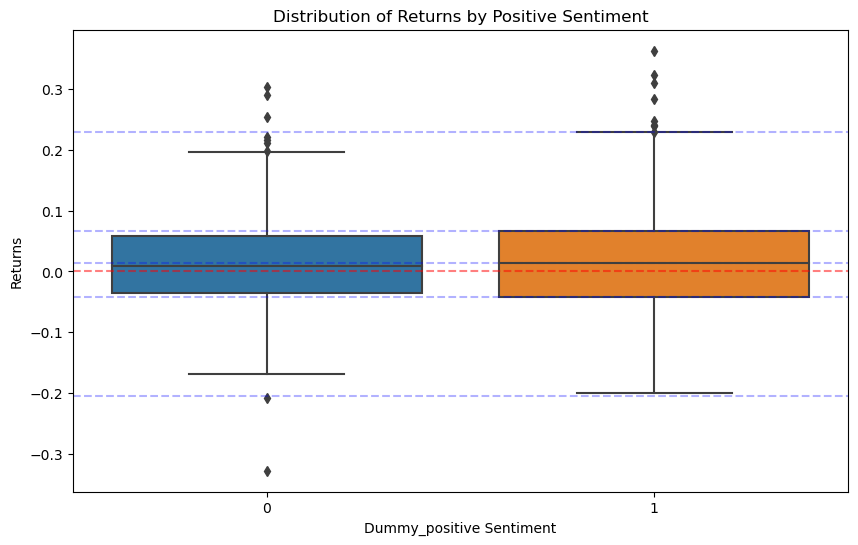

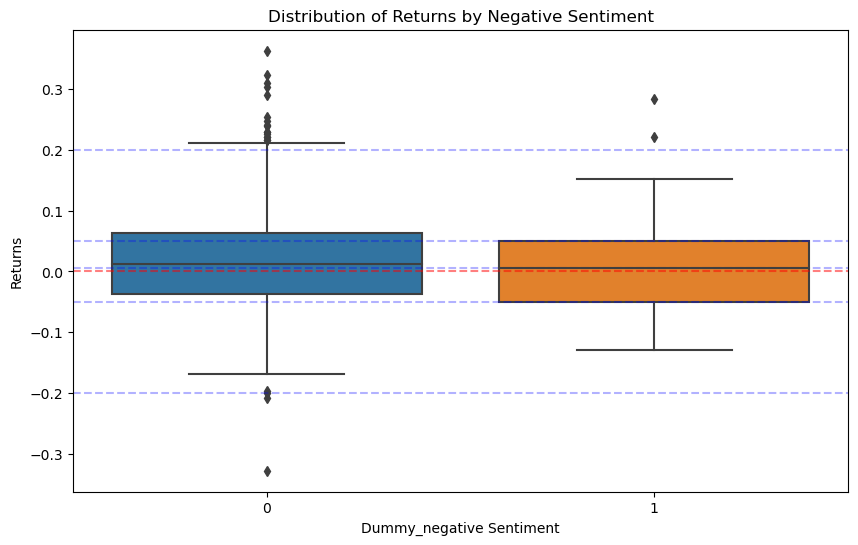

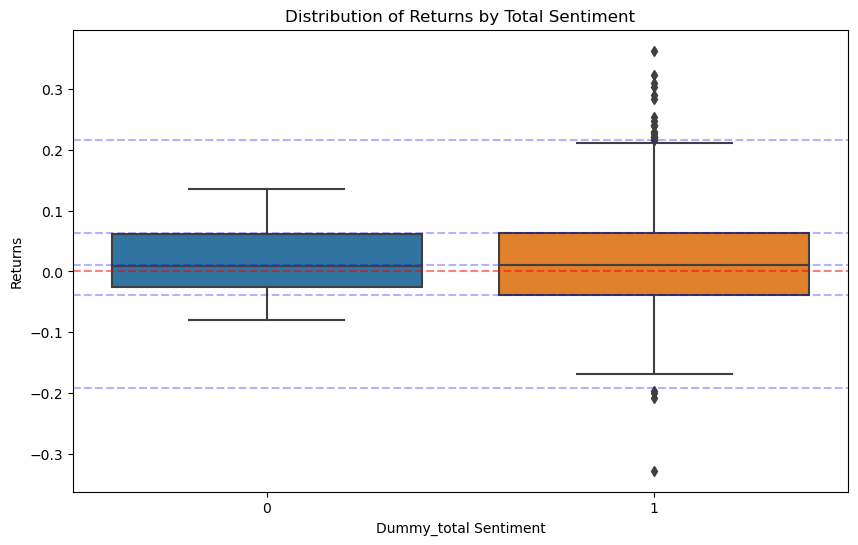

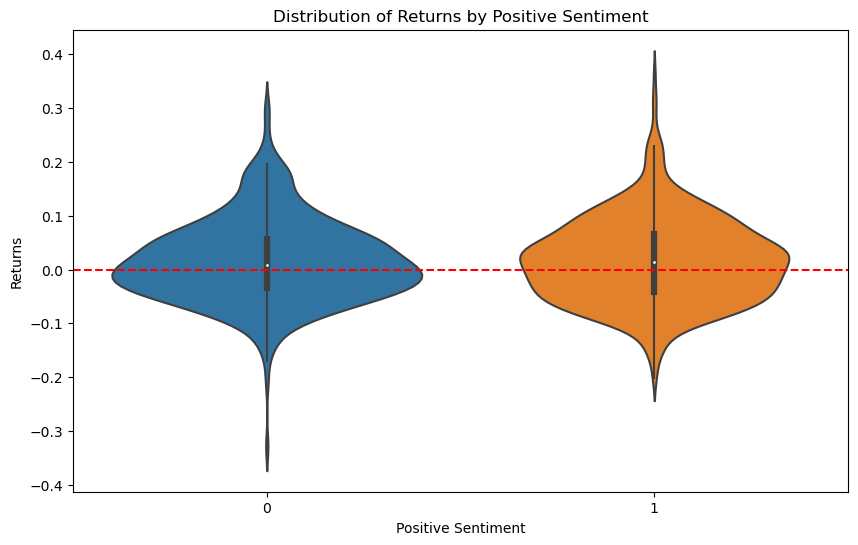

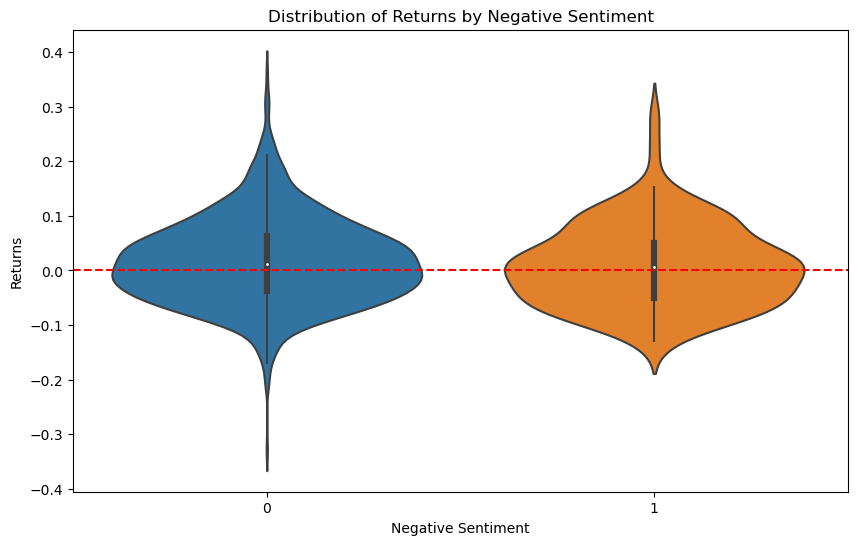

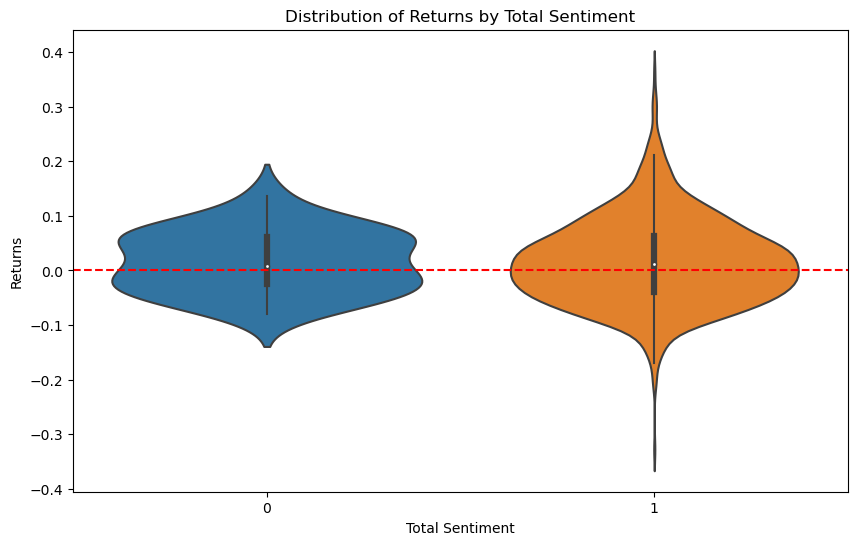

In [9]:
# Box plot for dummy_positive
plot_with_lines(nasdaq, 'dummy_positive', 'next_month_return', 'Distribution of Returns by Positive Sentiment')

# Box plot for dummy_negative
plot_with_lines(nasdaq, 'dummy_negative', 'next_month_return', 'Distribution of Returns by Negative Sentiment')

# Box plot for dummy_total
plot_with_lines(nasdaq, 'dummy_total', 'next_month_return', 'Distribution of Returns by Total Sentiment')

# Violin plot for dummy_positive
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_positive', y='next_month_return', data=nasdaq)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Positive Sentiment')
plt.xlabel('Positive Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_negative
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_negative', y='next_month_return', data=nasdaq)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Negative Sentiment')
plt.xlabel('Negative Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_total
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_total', y='next_month_return', data=nasdaq)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Total Sentiment')
plt.xlabel('Total Sentiment')
plt.ylabel('Returns')
plt.show()

In [10]:
from scipy.stats import ttest_ind, mannwhitneyu

# Define a function to remove outliers using Z-score
def remove_outliers(df, column, threshold=3):
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    df_filtered = df[(z_scores.abs() < threshold)]
    return df_filtered

# Remove outliers from the nasdaq DataFrame
nasdaq = remove_outliers(nasdaq, 'Ask_minus_Bid')
nasdaq = remove_outliers(nasdaq, 'VOL')
nasdaq.to_csv('monthly_nasdaq_regression.csv', index=False)

# Calculate mean and standard deviation (volatility) for each combination of dummy variables
mean_negative = nasdaq[nasdaq['dummy_negative'] == 1]['Ask_minus_Bid'].mean()
std_negative = nasdaq[nasdaq['dummy_negative'] == 1]['Ask_minus_Bid'].std()

mean_positive = nasdaq[nasdaq['dummy_positive'] == 1]['Ask_minus_Bid'].mean()
std_positive = nasdaq[nasdaq['dummy_positive'] == 1]['Ask_minus_Bid'].std()

mean_total = nasdaq[nasdaq['dummy_total'] == 1]['Ask_minus_Bid'].mean()
std_total = nasdaq[nasdaq['dummy_total'] == 1]['Ask_minus_Bid'].std()

# Calculate mean and standard deviation (volatility) when the dummy variables are equal to zero
mean_negative_zero = nasdaq[nasdaq['dummy_negative'] == 0]['Ask_minus_Bid'].mean()
std_negative_zero = nasdaq[nasdaq['dummy_negative'] == 0]['Ask_minus_Bid'].std()

mean_positive_zero = nasdaq[nasdaq['dummy_positive'] == 0]['Ask_minus_Bid'].mean()
std_positive_zero = nasdaq[nasdaq['dummy_positive'] == 0]['Ask_minus_Bid'].std()

mean_total_zero = nasdaq[nasdaq['dummy_total'] == 0]['Ask_minus_Bid'].mean()
std_total_zero = nasdaq[nasdaq['dummy_total'] == 0]['Ask_minus_Bid'].std()

# t-test for mean difference
t_statistic_mean_negative, p_value_mean_negative = ttest_ind(nasdaq[nasdaq['dummy_negative'] == 1]['Ask_minus_Bid'],
                                                             nasdaq[nasdaq['dummy_negative'] == 0]['Ask_minus_Bid'])

t_statistic_mean_positive, p_value_mean_positive = ttest_ind(nasdaq[nasdaq['dummy_positive'] == 1]['Ask_minus_Bid'],
                                                             nasdaq[nasdaq['dummy_positive'] == 0]['Ask_minus_Bid'])

t_statistic_mean_total, p_value_mean_total = ttest_ind(nasdaq[nasdaq['dummy_total'] == 1]['Ask_minus_Bid'],
                                                       nasdaq[nasdaq['dummy_total'] == 0]['Ask_minus_Bid'])

# Mann-Whitney U test for difference in volatility
u_statistic_vol_negative, p_value_vol_negative = mannwhitneyu(nasdaq[nasdaq['dummy_negative'] == 1]['Ask_minus_Bid'],
                                                              nasdaq[nasdaq['dummy_negative'] == 0]['Ask_minus_Bid'])

u_statistic_vol_positive, p_value_vol_positive = mannwhitneyu(nasdaq[nasdaq['dummy_positive'] == 1]['Ask_minus_Bid'],
                                                              nasdaq[nasdaq['dummy_positive'] == 0]['Ask_minus_Bid'])

u_statistic_vol_total, p_value_vol_total = mannwhitneyu(nasdaq[nasdaq['dummy_total'] == 1]['Ask_minus_Bid'],
                                                        nasdaq[nasdaq['dummy_total'] == 0]['Ask_minus_Bid'])

# Create a DataFrame to display the results
data = {
    'Dummy': ['Negative', 'Positive', 'Total'],
    'Mean_with_Dummy': [mean_negative, mean_positive, mean_total],
    'Mean_without_Dummy': [mean_negative_zero, mean_positive_zero, mean_total_zero],
    'Volatility_with_Dummy': [std_negative, std_positive, std_total],
    'Volatility_without_Dummy': [std_negative_zero, std_positive_zero, std_total_zero],
    'Mean_Difference': [mean_negative - mean_negative_zero,
                        mean_positive - mean_positive_zero,
                        mean_total - mean_total_zero],
    'Volatility_Difference': [std_negative - std_negative_zero,
                              std_positive - std_positive_zero,
                              std_total - std_total_zero],
    'Mean_P_value': [p_value_mean_negative, p_value_mean_positive, p_value_mean_total],
    'Volatility_P_value': [p_value_vol_negative, p_value_vol_positive, p_value_vol_total]
}
df_results = pd.DataFrame(data)

# Display the results
print(df_results)

      Dummy  Mean_with_Dummy  Mean_without_Dummy  Volatility_with_Dummy  \
0  Negative        27.344310           27.834915              32.468725   
1  Positive        25.717400           31.016304              29.774675   
2     Total        28.035095           17.182792              43.060381   

   Volatility_without_Dummy  Mean_Difference  Volatility_Difference  \
0                 43.513191        -0.490604             -11.044466   
1                 57.072129        -5.298904             -27.297454   
2                 14.055825        10.852303              29.004556   

   Mean_P_value  Volatility_P_value  
0      0.912108            0.610610  
1      0.038689            0.180801  
2      0.199736            0.123133  


In [11]:
# Specify the columns for which to calculate z-scores
columns_to_standardize = ['BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'SHROUT', 'sprtrn', 'market_cap', 'last_month_return', '1_month_ma', '2_month_ma', 
                          '3_month_ma', 'Ask_minus_Bid', 'last_month_volume']

# Group by ticker and standardize each group for specified columns
nasdaq_grouped = nasdaq.groupby('TICKER')[columns_to_standardize]

# Define a function to standardize values within each group
def standardize_group(group):
    group_std = (group - group.mean()) / group.std()
    return group_std

# Apply the standardization function to each group
nasdaq_standardized = nasdaq_grouped.transform(standardize_group)

# Replace original values with standardized values in the original DataFrame
nasdaq[columns_to_standardize] = nasdaq_standardized

# Check the modified DataFrame
print(nasdaq.head())

  TICKER       date   SICCD     COMNAM  market_cap    SHROUT       VOL  \
2   AAPL 2023-03-31  3571.0  APPLE INC   -1.885681  1.775630  1.476872   
3   AAPL 2023-04-30  3571.0  APPLE INC   -1.082235  0.758612 -0.937396   
4   AAPL 2023-05-31  3571.0  APPLE INC   -0.415016  0.798417  0.167308   
5   AAPL 2023-06-30  3571.0  APPLE INC    0.602585  0.756133  0.787482   
6   AAPL 2023-07-31  3571.0  APPLE INC    1.227155 -0.141964 -1.138965   

        PRC     ASKHI     BIDLO  ...  last_month_volume  1_month_ma  \
2 -1.918161 -1.791986 -1.997109  ...           1.487566   -1.918161   
3 -1.086902 -1.394240 -0.755083  ...           1.065070   -1.086902   
4 -0.462142 -0.615151 -0.400778  ...          -1.055437   -0.462142   
5  0.499387  0.625649  0.586320  ...          -0.085150    0.499387   
6  1.169619  0.933184  1.342595  ...           0.459563    1.169619   

   2_month_ma  3_month_ma  proper?  Ask_minus_Bid  comp_size  dummy_negative  \
2   -1.894106   -1.997785     True       0.70972

Kurtosis:
BIDLO               -0.668798
ASKHI               -0.769057
PRC                 -0.785660
VOL                  0.008313
RET                 -0.754631
SHROUT              -0.674372
sprtrn              -1.093728
market_cap          -0.778383
last_month_return   -0.728525
1_month_ma          -0.785660
2_month_ma          -0.931744
3_month_ma          -1.022692
Ask_minus_Bid        0.034721
last_month_volume   -0.099045
dtype: float64

Skewness:
BIDLO                0.044984
ASKHI                0.004799
PRC                  0.065720
VOL                  0.475049
RET                  0.082678
SHROUT               0.038552
sprtrn               0.017289
market_cap           0.061155
last_month_return    0.129295
1_month_ma           0.065720
2_month_ma          -0.003738
3_month_ma          -0.104134
Ask_minus_Bid        0.663207
last_month_volume    0.462792
dtype: float64


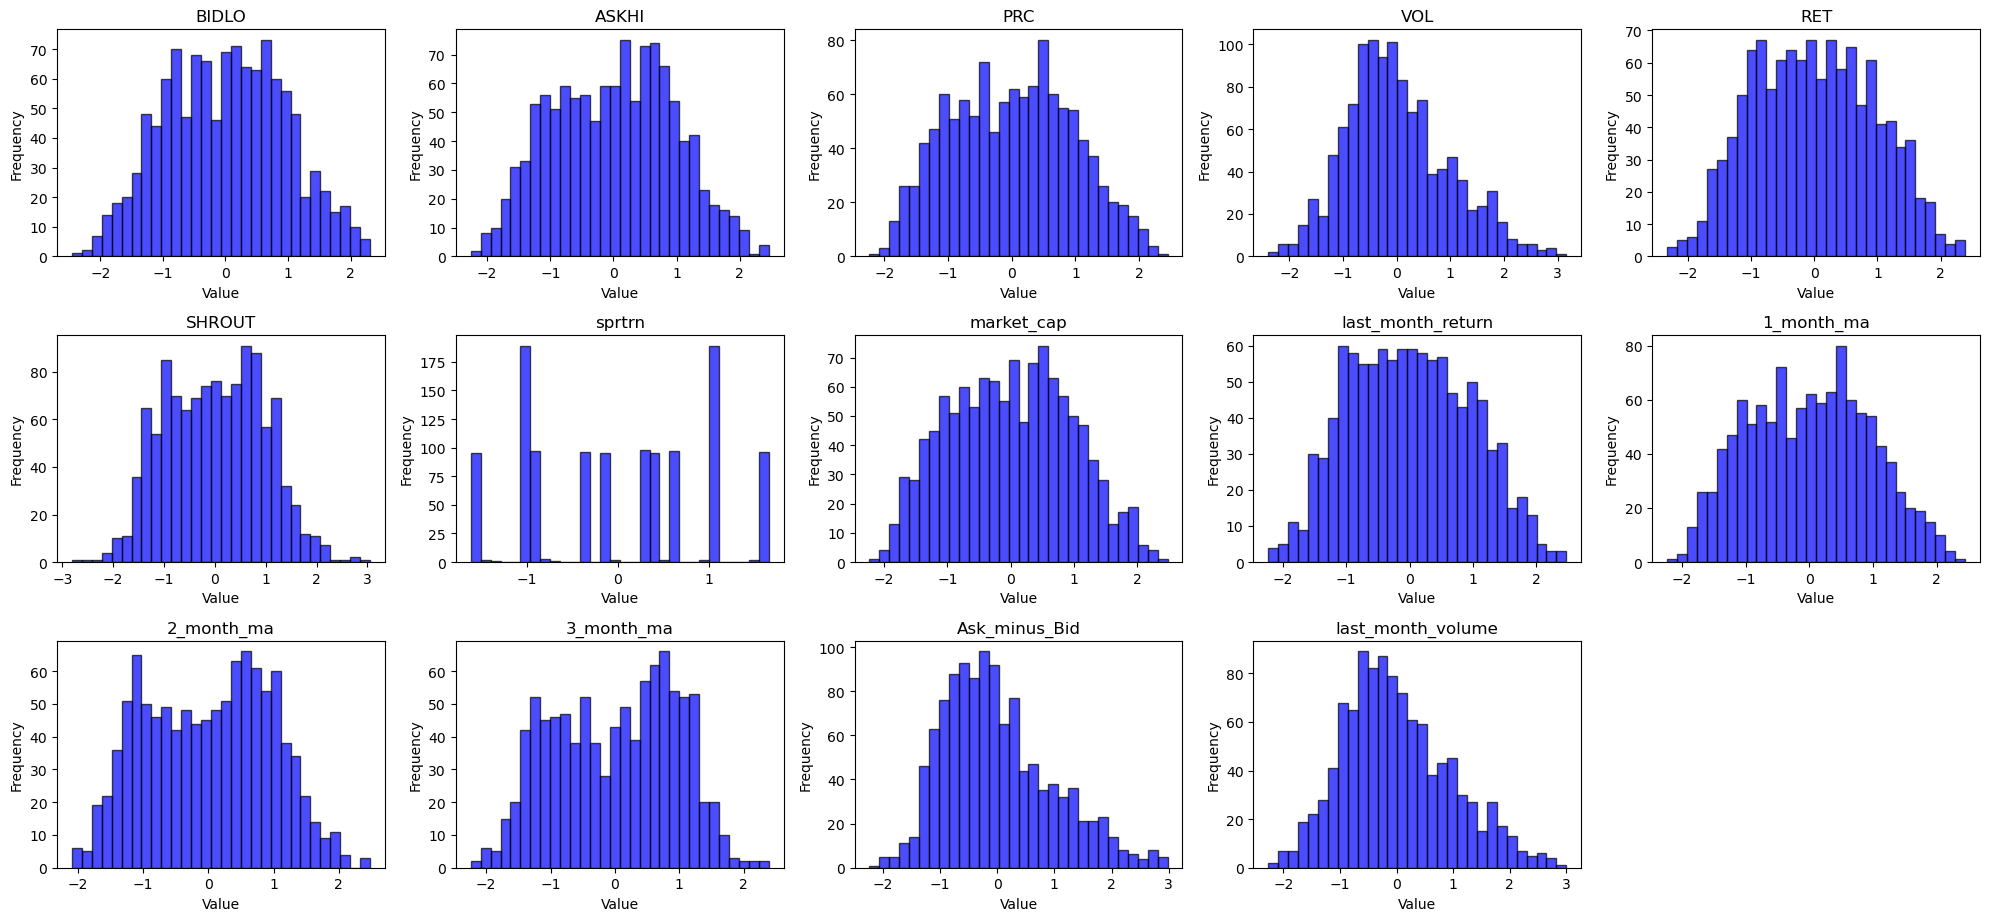

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate kurtosis and skewness for each numeric variable
numeric_columns = ['BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'SHROUT', 'sprtrn', 'market_cap', 'last_month_return', 
                   '1_month_ma', '2_month_ma', '3_month_ma', 'Ask_minus_Bid', 'last_month_volume']
kurtosis_values = nasdaq[numeric_columns].kurtosis()
skewness_values = nasdaq[numeric_columns].skew()

# Print kurtosis and skewness values for each numeric variable
print("Kurtosis:")
print(kurtosis_values)
print("\nSkewness:")
print(skewness_values)

# Plot histograms for each numeric variable
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 5, i)
    plt.hist(nasdaq[col], bins=30, color='blue', edgecolor='black', alpha=0.7)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [13]:
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1162 entries, 2 to 1194
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TICKER             1162 non-null   object        
 1   date               1162 non-null   datetime64[ns]
 2   SICCD              1162 non-null   float64       
 3   COMNAM             1162 non-null   object        
 4   market_cap         1162 non-null   float64       
 5   SHROUT             1162 non-null   float64       
 6   VOL                1162 non-null   float64       
 7   PRC                1162 non-null   float64       
 8   ASKHI              1162 non-null   float64       
 9   BIDLO              1162 non-null   float64       
 10  total              1162 non-null   float64       
 11  negative           1162 non-null   float64       
 12  positive           1162 non-null   float64       
 13  sprtrn             1162 non-null   float64       
 14  RET     

In [14]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector

# Convert specified columns to categorical
nasdaq['SICCD'] = nasdaq['SICCD'].astype('category')
nasdaq['comp_size'] = nasdaq['comp_size'].astype('category')
nasdaq['proper?'] = nasdaq['proper?'].astype('category')
nasdaq['dummy_negative'] = nasdaq['dummy_negative'].astype('category')
nasdaq['dummy_positive'] = nasdaq['dummy_positive'].astype('category')
nasdaq['dummy_total'] = nasdaq['dummy_total'].astype('category')

nasdaq.to_csv('standardized_monthly_nasdaq_regression.csv', index=False)
nasdaq_clean = nasdaq.dropna()

# Select features and target variable
features = nasdaq_clean.drop(columns=['next_month_return', 'TICKER', 'COMNAM', 'date'])
target = nasdaq_clean['next_month_return']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="object")),
        ('cat', categorical_transformer, selector(dtype_include="object"))
    ])

# Define LassoCV model
lasso_cv = LassoCV(cv=5, random_state=42)

# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('lasso', lasso_cv)])

# Fit the model
pipeline.fit(X_train, y_train)

# Print the best alpha
print("Best alpha:", pipeline.named_steps['lasso'].alpha_)

# Print the R^2 score
print("R^2 score:", pipeline.score(X_test, y_test))

# Access the model coefficients
model_coefs = pipeline.named_steps['lasso'].coef_
print("Model coefficients:", model_coefs)

KeyError: "['tomorrow_return'] not found in axis"

In [ ]:
nasdaq = nasdaq.dropna()

# Add a new column 'pred_lasso' to the nasdaq dataframe with predictions
nasdaq['pred_lasso'] = pipeline.predict(nasdaq.drop(columns=['tomorrow_return', 'TICKER', 'COMNAM', 'date']))

# Display the first few rows of the dataframe to verify the new column
print(nasdaq.head())

plt.hist(nasdaq['pred_lasso'], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Predicted Lasso Distribution')
plt.xlabel('Predicted Lasso Returns')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=12)

# Create pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('random_forest', rf_model)])

# Define parameter grid
param_grid = {
    'random_forest__n_estimators': [50, 100],
    'random_forest__max_depth': [None, 10],
    'random_forest__min_samples_split': [2, 5],
    'random_forest__min_samples_leaf': [1, 2]
}

# Perform grid search with reduced parameters and folds
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Print the best R^2 score
print("Best R^2 score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_score = best_model.score(X_test, y_test)
print("Test set R^2 score of the best model:", test_score)
